# Customer Segmentation

In [11]:
#import libraries

In [12]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns


Load Data

In [13]:
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")

Merge Data

In [14]:
merged = transactions.merge(customers, on="CustomerID", how="left")

Feature Engineering

In [15]:
customer_features = merged.groupby("CustomerID").agg(
    total_spend=("Price", "sum"),
    avg_spend=("Price", "mean"),
    num_transactions=("TransactionID", "count")
).reset_index()

Combine with customer demographics

In [16]:
customer_profiles = customer_features.merge(customers[["CustomerID", "Region", "SignupDate"]], on="CustomerID", how="left")

One-hot encode

In [17]:
customer_profiles = pd.get_dummies(customer_profiles, columns=["Region"], drop_first=True)

Scaling Features

In [20]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_profiles.drop(columns=["CustomerID", "SignupDate"]))

K-Means Clustering

In [24]:
# K-Means Clustering with k in range [2, 10]
import warnings
warnings.filterwarnings('ignore')
dbi_scores = []
k_range = range(2, 11)  # k values between 2 and 10

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    customer_profiles[f'Cluster_{k}'] = kmeans.fit_predict(scaled_features)
    
    # Calculate Davies-Bouldin Index for this clustering
    dbi = davies_bouldin_score(scaled_features, customer_profiles[f'Cluster_{k}'])
    dbi_scores.append(dbi)
    print(f"DB Index for k={k}: {dbi}")

DB Index for k=2: 1.756487729921195
DB Index for k=3: 1.294450280679287
DB Index for k=4: 1.2062663734927819
DB Index for k=5: 1.113399776747031
DB Index for k=6: 1.0111993648355604
DB Index for k=7: 0.9765280137579607
DB Index for k=8: 0.9226015406797958
DB Index for k=9: 0.848424959966636
DB Index for k=10: 0.8640054821990638


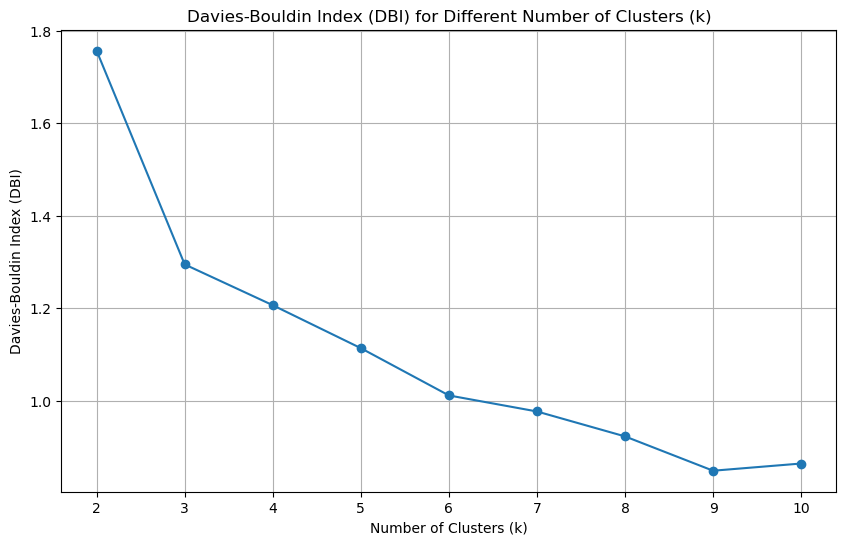

In [25]:
# Visualize DBI scores for different k values
plt.figure(figsize=(10, 6))
plt.plot(k_range, dbi_scores, marker='o')
plt.title('Davies-Bouldin Index (DBI) for Different Number of Clusters (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Index (DBI)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [26]:
# Choose the best k (lowest DBI score)
best_k = k_range[dbi_scores.index(min(dbi_scores))]
print(f"The best number of clusters (k) based on DBI is: {best_k}")

The best number of clusters (k) based on DBI is: 9


In [27]:
# Final K-Means with the best k
final_kmeans = KMeans(n_clusters=best_k, random_state=42)
customer_profiles['Final_Cluster'] = final_kmeans.fit_predict(scaled_features)

In [28]:
# Visualizing the final clustering result using PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)

In [30]:
# Add PCA components to the DataFrame
customer_profiles['PCA1'] = pca_components[:, 0]
customer_profiles['PCA2'] = pca_components[:, 1]

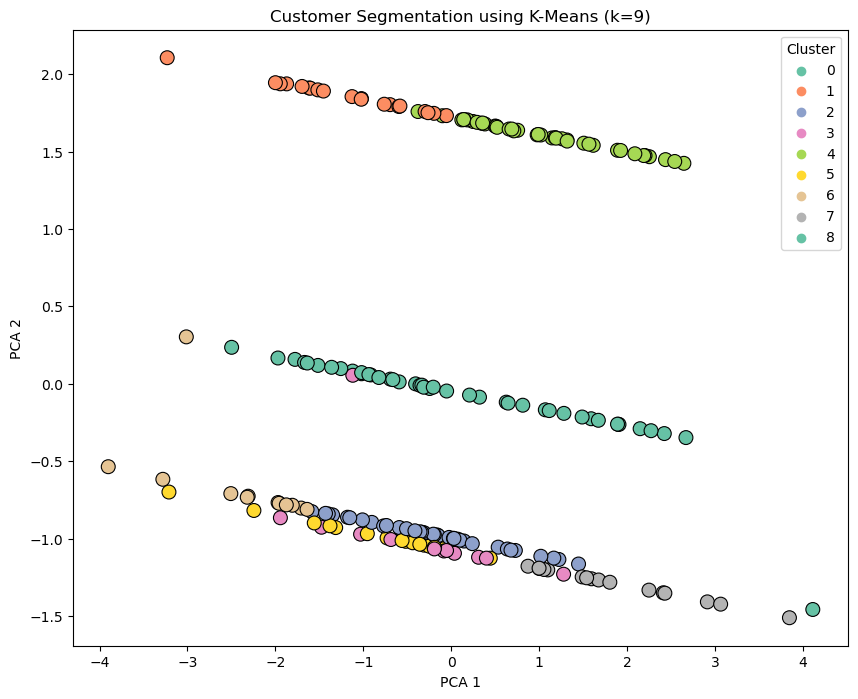

In [31]:
# Plotting the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Final_Cluster', data=customer_profiles, palette="Set2", s=100, edgecolor='k')
plt.title(f'Customer Segmentation using K-Means (k={best_k})')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Cluster')
plt.show()
